In [167]:
'''
Title:       Optimale Steuerung und Regelung:
Subttitle:   3. Aufgabe
Author:      Stefan Kaufmann
MaNr.        51867606
Date:        06.06.2023
'''

'\nTitle:       Optimale Steuerung und Regelung:\nSubttitle:   3. Aufgabe\nAuthor:      Stefan Kaufmann\nMaNr.        51867606\nDate:        06.06.2023\n'

# Optimale Steuerung und Regelung
## 3. Randwertproblem
### Stefan Kaufmann - 51867606

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import sympy as sym

import casadi as cas
import libop as libop

# 1. Model    
    
$
\dot{X}(t) = f (x(t),u(t)) = 
\begin{bmatrix}
\omega (t) \\
\frac{mga sin{\Theta (t) -d \omega(t) +mau(t) cos{\Theta (t)}}}{J+ma^{2}} \\
v(t) \\
u(t)
\end{bmatrix}
$

In [305]:
# System dynamic
def System_dynamic(x,u):
    dx = np.zeros(nx)
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx

# 2. Zwei-Punkt Randwertproblem Allgemein 

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.27e-04       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 1.27e-04 
Maximum boundary residual: 0.00e+00


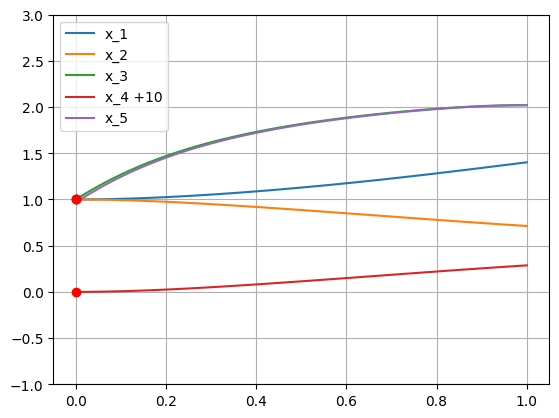

In [307]:
t = np.linspace(0,1,50)

def System(t,x):
    dx = np.zeros_like(x)
       
    dx[0] = x[0]*(x[2]-x[0])/(2*x[1])
    dx[1] = -0.5*(x[2]-x[0])
    dx[2] = (0.9-1000*(x[2]-x[4])-0.5*x[2]*(x[2]-x[0]))/x[3]
    dx[3] = 0.5*(x[2]-x[0])
    dx[4] = -100*(x[4]-x[2])        
    
    return dx

def bc(ya,yb):
    
    return [ya[0]-1,ya[1]-1,ya[2]-1,ya[3]+10, yb[4]-yb[2] ] 

y = np.zeros((5,len(t))) 

y0 = np.zeros((5,len(t))) 

# Boundary conditions
ya = y0[0,:]    # Startbedingung
yb = y0[-1,:]   # Endbedingung

# # Startlösung 
for i in range(0,len(t)):
    y0[0,i] = 1
    y0[1,i] = 1
    y0[2,i] = -4.5*(t[i]**2) +8.91*t[i] + 1
    y0[3,i] = -10
    y0[4,i] = -4.5*(t[i]**2)+9*t[i] + 0.91              





res = solve_bvp(System, bc, t, y0, verbose = 2)

plt.plot(res.x,res.y[0],label = 'x_1')
plt.plot(res.x,res.y[1],label = 'x_2')
plt.plot(res.x,res.y[2],label = 'x_3')
plt.plot(res.x,res.y[3]+10,label = 'x_4 +10')
plt.plot(res.x,res.y[4],label = 'x_5')
plt.grid()
plt.legend()
plt.ylim((-1,3))

# Plotten der Randwerte
plt.plot(np.zeros(4), [1,1,1,0], 'ro')

# 3. Problemsetup 

## 3.1 Aufstellen der Hamilton Funktion
$
H(x,u,\lambda,u) = l(x,u,t) + \lambda^{T} f(x,u,t) \\
H(x,u,\lambda,u) = 1 + \frac{1}{2} (x^{T}Qx + u^{T}Ru)  + \lambda^{T} f(x,u,t)   
$    
    
## 3.2 Steuerungsgleichung
$
H_{u} = 0 = Ru + \lambda_{4} + \lambda_{2} \frac{ma cos(\theta)}{J+ma^{2}} \\
u = - \frac{\lambda_{4}}{R}  - \lambda_{2} \frac{ma cos(\theta)}{R(J+ma^{2})}
$   


## 3.3 Kanonische Gleichung   
$
\dot{x} = f(x,\lambda) = H_{\lambda}  \\
\dot{\lambda} = -H_{x}
$

In [272]:
theta, omega, s, v, l1, l2, l3, l4, m,a,g,d,J,u, R, q1,q2,q3,q4, P , J_= sym.symbols("theta omega s v lambda_1 lambda_2  lambda_3  lambda_4  m a g d J u R q1 q2 q3 q4 P J_quer")

Q = sym.Matrix([[q1,0,0,0,],[0,q2,0,0],[0,0,q3,0],[0,0,0,q4]])
x = sym.Matrix([theta,omega,s,v])
l = sym.Matrix([l1,l2,l3,l4])
dx = sym.Matrix([omega,
                 P*g*sym.sin(theta)+ P*sym.cos(theta)*u + -d*omega /J_
                 ,v
                 ,u])
#display(dx)

u_ = -l4/R -l2*sym.cos(theta)*P/R
#display(u_)

# Hamiltonfunktion
H =  l.T@dx  +(x.T@Q@x )/2
H[0] +=(R*u**2)/2 +1
display(H)

Matrix([[R*u**2/2 + lambda_1*omega + lambda_2*(P*g*sin(theta) + P*u*cos(theta) - d*omega/J_quer) + lambda_3*v + lambda_4*u + omega**2*q2/2 + q1*theta**2/2 + q3*s**2/2 + q4*v**2/2 + 1]])

In [302]:
# Berechnung der Ableitungen
dx_ =  H.jacobian(l)
dl =  -H.jacobian(x)


display(sym.simplify(dx_.T))
display(sym.simplify(dl.T))


Matrix([
[                                                    omega],
[(J_quer*P*(g*sin(theta) + u*cos(theta)) - d*omega)/J_quer],
[                                                        v],
[                                                        u]])

Matrix([
[-P*lambda_2*(g*cos(theta) - u*sin(theta)) - q1*theta],
[            -lambda_1 - omega*q2 + d*lambda_2/J_quer],
[                                               -q3*s],
[                                    -lambda_3 - q4*v]])

## 3.4 Nummerische Lösung

In [308]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R


t_end = 4
N = 50
t = np.linspace(0,t_end,N+1)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

M = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

Q = np.eye(4)
S = np.diag([0,0,5,0])
R = 0.1

# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [309]:
x0 = [np.pi, 0, 0, 0]
xN = [0,0 ,0,0]
umax = 12
umin = -12

In [310]:
def Hamilton(x):
    J_quer = J +m*a**2
    P = m*a/(J_quer)
    u = -x[5]*np.cos(x[0])*P/R -x[7]/R
    h = 1 + 0.5*(x[:nx].T@Q@x[:nx] + R*u**2) + x[4]*x[1] + x[5]*(g*P*np.sin[x[0]]- d*x[1]/J_quer + P*np.cos(x[0])*u) + x[6]*x[3] +x[7]*u
    return h

In [311]:
def Pendel_dynamic(t,x):
    # x = [phi, omega, x, v, l1, l2, l3, l4]
    dx = np.zeros_like(x)      
    
    J_quer = J +m*a**2
    P = m*a/(J_quer)
    u = -x[5]*np.cos(x[0])*P/R -x[7]/R
    
    dx[0] = x[1]
    dx[1] = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u
     
    dx[4] =  -P*x[5]*(g*np.cos(x[0])-u*np.sin(x[0])) #-P**2 *x[5]**2 * np.sin(2*x[0])/(2*R) - P*g*x[5]*np.cos(x[0]) - P*x[5]*x[7]*np.sin(x[0])/R #-(g*P*np.cos(x[0])+P**2 *2*np.cos(x[0])*np.sin(x[0])*x[5]/R + P*np.sin(x[0])*x[7]/R)*x[5] -(x[5]*P*np.sin(x[0])/R)*x[7]  -np.sin(x[0])*P*x[5]*u  
    dx[5] = -x[4] + d*x[5]/J_quer
    dx[6] =  0
    dx[7] = -x[6] 

    dx[4:] -= Q@x[:nx]    # = -dl/dx

    return dx

In [312]:
# Boundary Conditions

def bc(ya,yb):
    ''' define the boundary conditions '''
    # ya are the initial values
    # yb are the final values
    # each entry of the return array will be set to zero
    bcon = np.zeros(nx*2)
    bcon[:nx]  = ya[:nx] - x0
    bcon[4] = yb[0] - xN[0] 
    bcon[5] = yb[1] - xN[1] 
    bcon[6] = yb[6] - S[2,2]*yb[2]
    bcon[7] = yb[3] - xN[3]  
    return bcon 

In [313]:
# Lösung 
y0 = np.ones((nx*2,N+1))

# Inital Conditions
#X_load = np.load('X4.npy')
#U_load = np.load('U4.npy')

y0[:nx,:] = X_load
y0[-1,:] =  U_load

# Solve the system.
sol = solve_bvp(Pendel_dynamic, bc, t, y0, verbose = 2, tol=1e-9, bc_tol = 1e-4, max_nodes=1000)



def Eingang(x):
    u = np.zeros(len(x[0]))

    for i in range(0,len(u)):
        u[i] = -x[5,i]*m*a*np.cos(x[0,i])/(R*(J+m*a**2)) - x[7,i]/R
    return u

U = Eingang(sol.y)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.71e+02       2.30e-11          51             100      
       2          4.50e+02       1.12e-09          151            300      
       3          1.10e+03       2.56e-09          451           (900)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 1.10e+03 
Maximum boundary residual: 2.56e-09


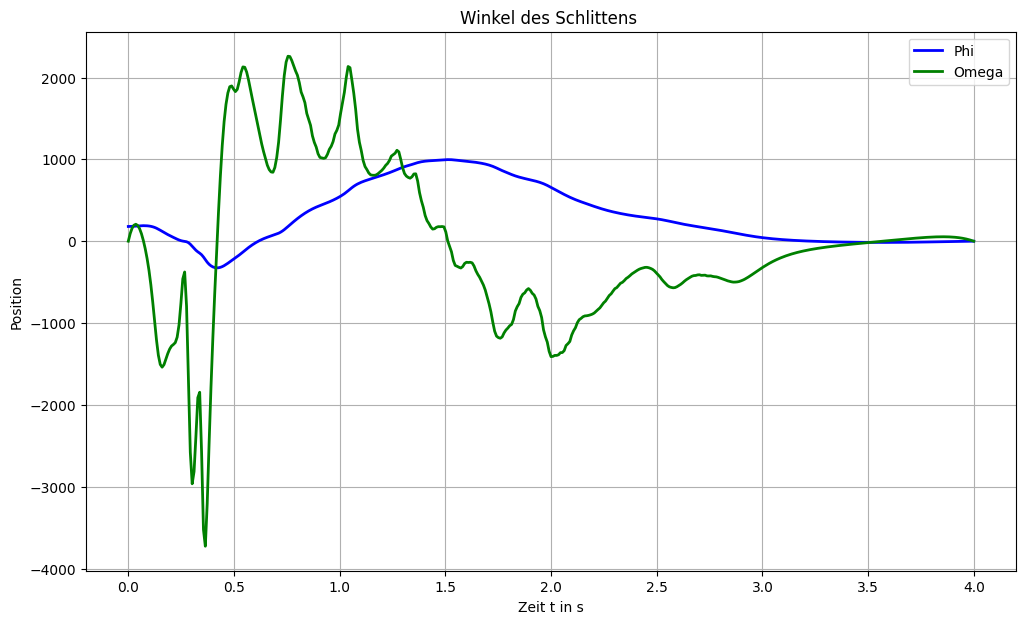

In [314]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Position')
plt.grid()
plt.plot(sol.x,sol.y[0]*180/np.pi,'b', linewidth ='2', label = 'Phi')
plt.plot(sol.x,sol.y[1]*180/np.pi,'g', linewidth ='2', label = 'Omega')

plt.title('Winkel des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

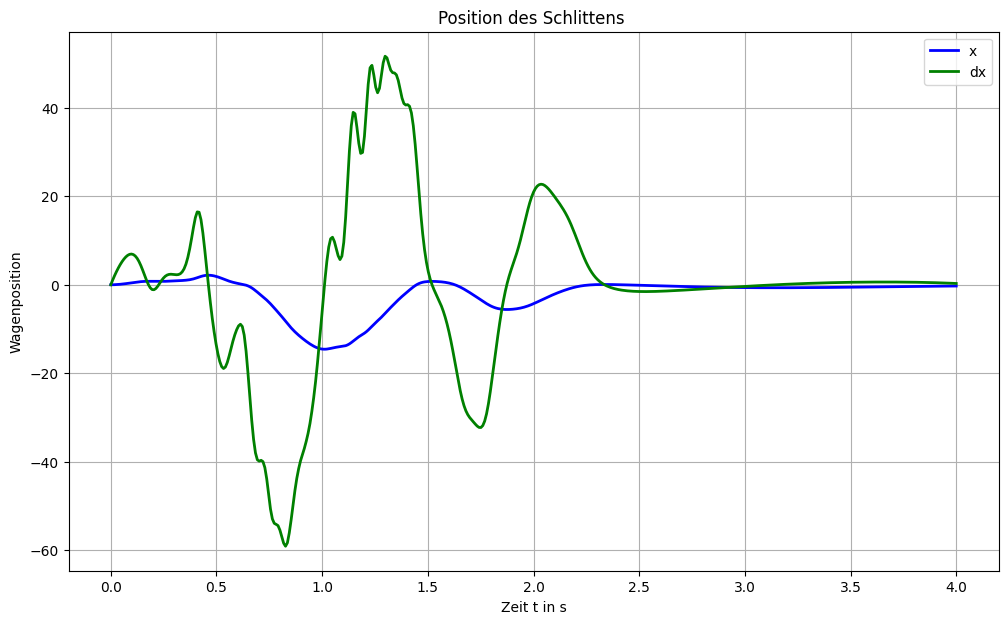

In [294]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Wagenposition')
plt.grid()
plt.plot(sol.x,sol.y[2],'b', linewidth ='2', label = 'x')
plt.plot(sol.x,sol.y[3],'g', linewidth ='2', label = 'dx')

plt.title('Position des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

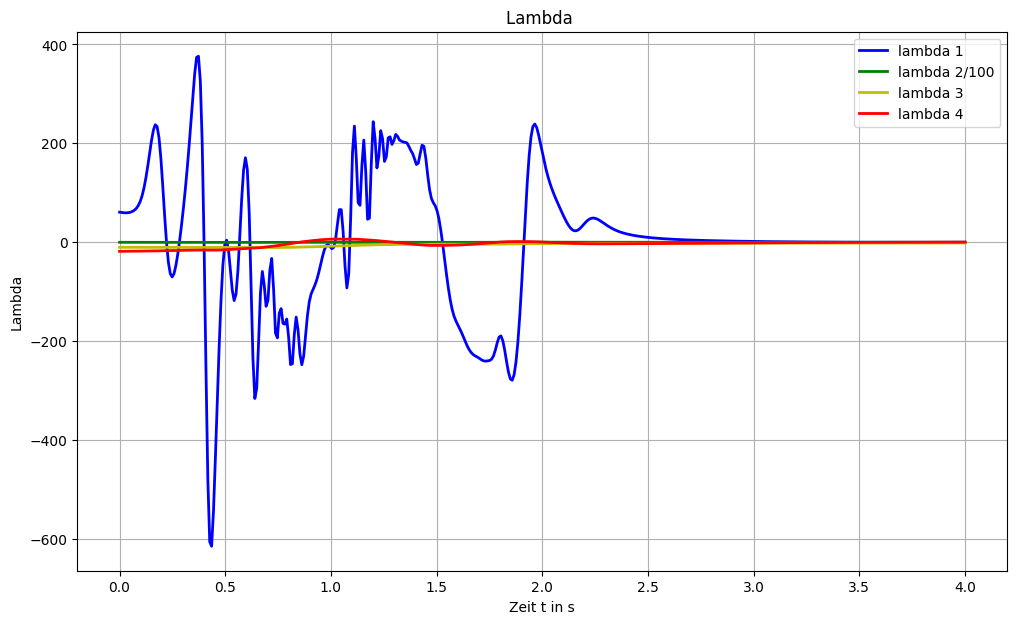

In [295]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Lambda')
plt.grid()
plt.plot(sol.x,sol.y[4],'b', linewidth ='2', label = 'lambda 1')
plt.plot(sol.x,sol.y[5]/100,'g', linewidth ='2', label = 'lambda 2/100')
plt.plot(sol.x,sol.y[6],'y', linewidth ='2', label = 'lambda 3')
plt.plot(sol.x,sol.y[7],'r', linewidth ='2', label = 'lambda 4')

plt.title('Lambda ')   
plt.legend(loc = 'best')
plt.show()

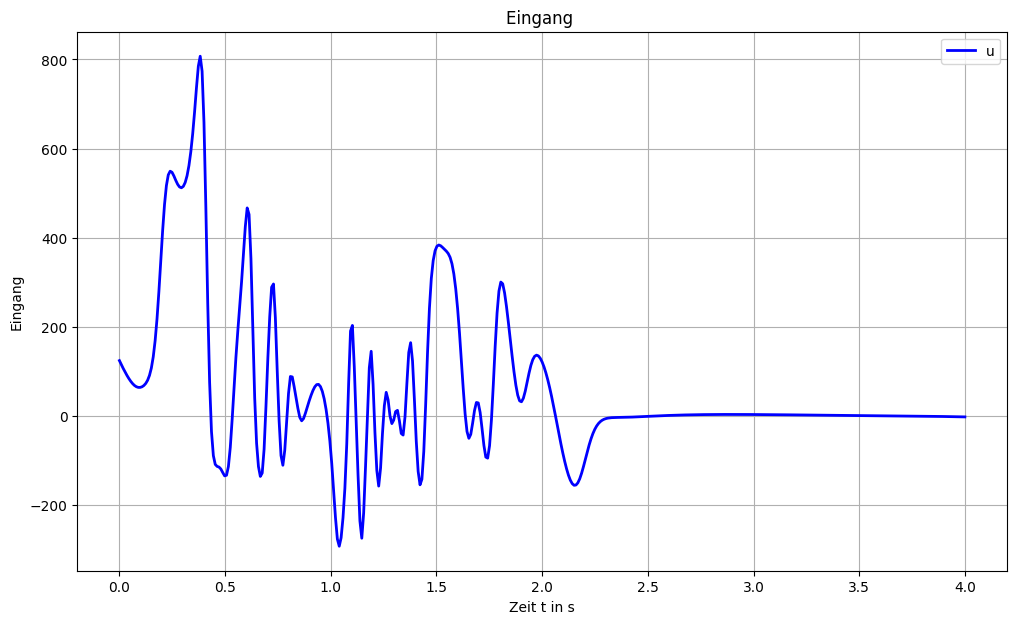

In [296]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Eingang')
plt.grid()
plt.plot(sol.x,U,'b', linewidth ='2', label = 'u')


plt.title('Eingang ')   
plt.legend(loc = 'best')
plt.show()

# Überprüfung

In [297]:
import control as ct
import control.optimal as obc


def system_update(t, x, u,params):
    # Return the derivative of the state
    return System_dynamic(x,u)

def system_output(t, x, u,params):
    return x

# Define the vehicle steering dynamics as an input/output system
Pendel = ct.NonlinearIOSystem(
    system_update, system_output, states=4, name='Pendel',
    inputs=('u'), outputs=('phi','omega','x','dx'))

timepts = np.linspace(0,t_end, 500)
U_inter = np.interp(timepts, sol.x,U)
input = U ;  timepts = sol.x


resp = ct.input_output_response(
    Pendel, timepts, input, x0,
    t_eval=t)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


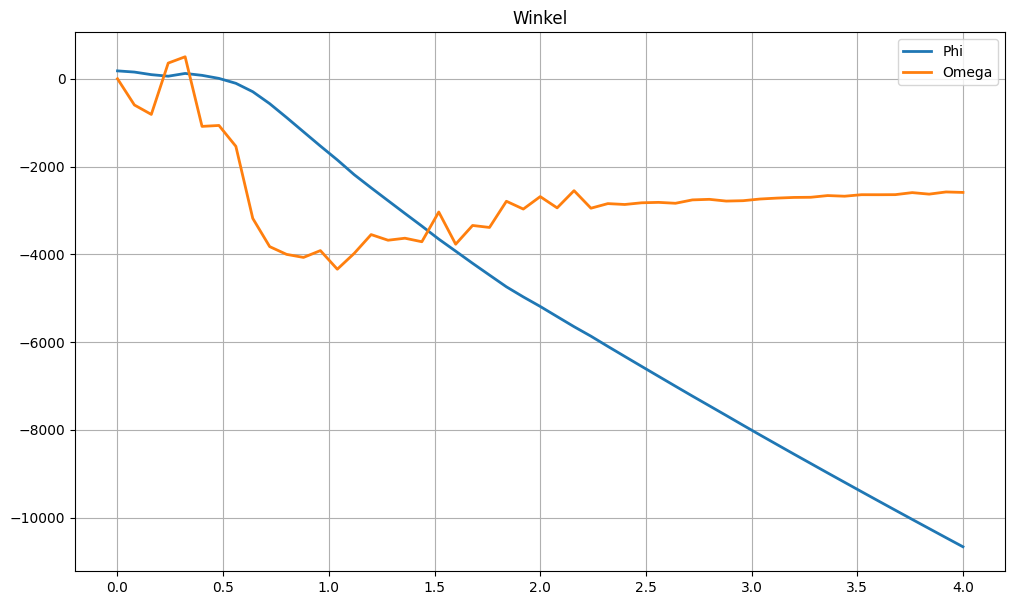

In [298]:
plt.figure(figsize=(12,7))
plt.figure(1)
#plt.plot(t_sim, y_sim[0])
plt.plot(t_sim, y_sim[0]*180/np.pi, linewidth ='2', label = 'Phi')
plt.plot(t_sim, y_sim[1]*180/np.pi, linewidth ='2', label = 'Omega')
plt.grid()
plt.title('Winkel')
plt.legend(loc = 'best')

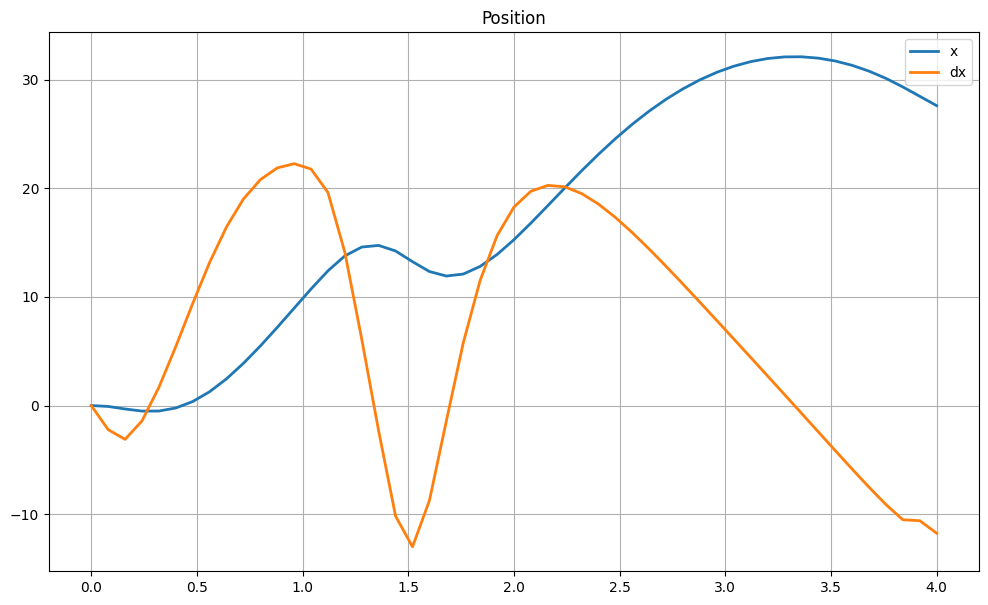

In [187]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, y_sim[2], linewidth ='2', label = 'x')
plt.plot(t_sim, y_sim[3], linewidth ='2', label = 'dx')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Position')
plt.legend(loc = 'best')

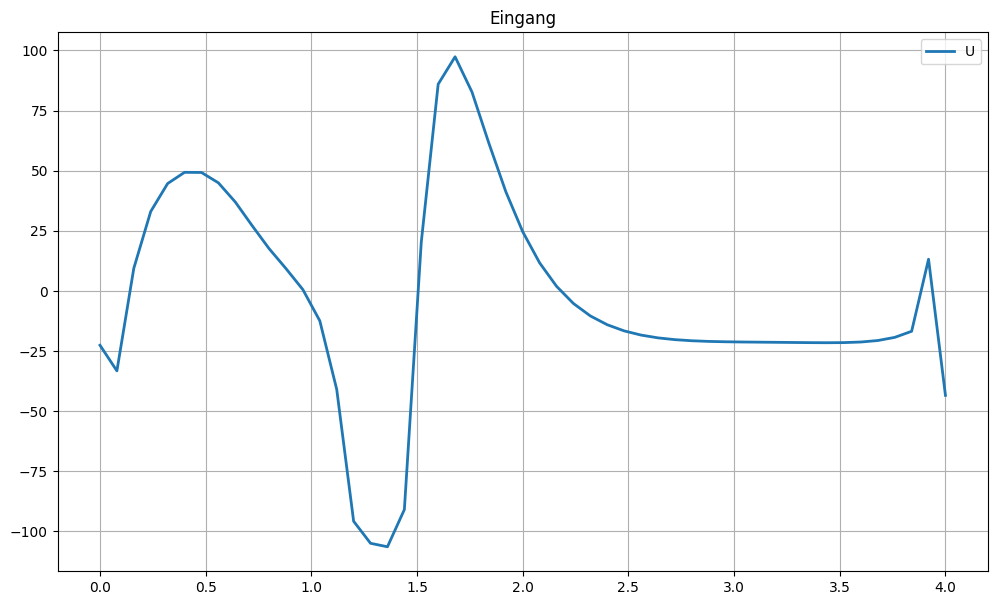

In [188]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, u_sim[0], linewidth ='2', label = 'U')
plt.grid()
plt.title('Eingang')
plt.legend(loc = 'best')